### 4장에서 다룰 내용
선형회귀 / 
릿지, 라쏘 회귀 / 
다항 회귀 / 
경사 하강법 /
로지스틱 회귀

In [1]:
# data load 등을 위한 chdir
import os
os.chdir("../introduction_to_ml_with_python-master/")

# graph 출력을 위한 기본설정
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고 문구 출력 방지를 위한 설정
import warnings
warnings.filterwarnings(action='ignore')

# basic packages import
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

### 정규 방정식을 사용한 선형 회귀

In [2]:
# 0~2의 난수 100개 생성
X = 2 * np.random.rand(100, 1)

# 3~7인 난수와 표준분포로부터 출력된 값을 합친 값 100개 생성
y = 4 + 3 * X + np.random.randn(100, 1)

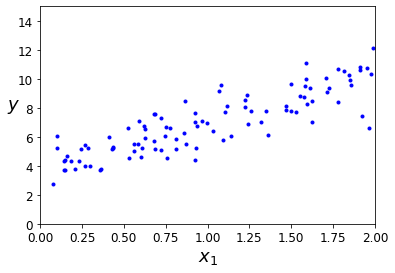

In [3]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [4]:
# (100, 1) 사이즈로 1이 채워진 값과 X 행렬을 열방향으로 병합하여 절편 표현
X_b = np.c_[np.ones((100, 1)), X]

# 정규방정식 구현
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

# 최적의 theta 값 확인
theta_best

# '''
# 위의 식을 따라가면 아래와 같다.

# X_b = (100, 2)차원
# y = (100, 1)차원

# X_b.T = (2, 100)차원
# X_b.T * X_b = (2, 2)차원
# (2, 2)차원의 역행렬 = (2, 2)차원
# (2, 2)차원 * X_b.T = (2, 100)차원
# (2, 100)차원 * y = (2, 1)차원

# 최종 출력은 (2, 1)차원임.
# index 0의 행은 절편에 대한 추청 값임.
# index 1의 행은 세타에 대한 추정 값임.
# '''

array([[3.80229089],
       [3.17243939]])

$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [5]:
# x가 0과 2일떄의 추정값을 구하기 위해 생성
X_new = np.array([[0], [2]])

# 절편 추가
X_new_b = np.c_[np.ones((2, 1)), X_new]

# y값에 대한 추정공식 구현
y_predict = X_new_b.dot(theta_best)

# 추정한 y값 확인
y_predict

array([[ 3.80229089],
       [10.14716968]])

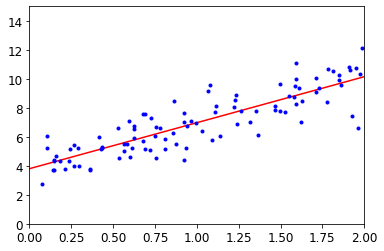

In [6]:
# 0과 2를 추정한 값을 이어 그래프로 표시
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# LinearRegression을 통한 데이터 학습
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.80229089]), array([[3.17243939]]))

In [8]:
# lin_reg 모델로 X_new 데이터에 대한 예측
lin_reg.predict(X_new)

# '''
# sklearn의 lin_reg 모델이 위에 만든 모델과 동일하게 작동 하는 것을 확인할 수 있음.
# 실제로 sklearn은 동일한 수식을 사용함.
# '''

array([[ 3.80229089],
       [10.14716968]])

In [9]:
# lin_reg 모델이 내부적으로 사용하는 scipy 메서드로 구현
import scipy

theta_best_svd, residuals, rank, s = scipy.linalg.lstsq(X_b, y, 1e-6)
theta_best_svd

# '''
# theta_best_svd는 수식을 통해 찾은 최적의 theta 값임.
# svd의 의미는 1차원 벡터의 의미이고, lstsq함수가 내부적으로 사용함.
# svd 방식으로 이 특잇값을 구할 수 있고, rcond값(1e-6)을 곱해 최대 특잇값을 구함.
# 최대 특이값보다 작은 값은 0으로 수렴시키므로써, 이를 통해 유사역행렬을 구할 수 있음.
# 역행렬을 구할 수 없는 경우가 있기 떄문에, 유사역행렬을 구함.
# residuals는 최적의 theta를 통해 구해진 MSE값임.
# rank는 행렬의 rank로 독립적인 행의 값임.
# '''

array([[3.80229089],
       [3.17243939]])

In [10]:
# 유사역행렬을 통해 구현
np.linalg.pinv(X_b).dot(y)

array([[3.80229089],
       [3.17243939]])

### 배치 경사 하강법을 사용한 선형 회귀

비용 함수의 그레이디언트 벡터

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

경사 하강법의 스텝

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

In [11]:
# learning rate
eta = 0.1

# 반복 횟수
n_iterations = 1000

# sample의 갯수
m = 100

# theta값 임의로 지정 (절편과 특성 x1을 찾아야 하기에 (2, 1)차원임.)
theta = np.random.randn(2, 1)

# 경사하강법 구현
for iteration in range(n_iterations) :
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    pass # loss function

# 예측한 theta 값 확인
theta

array([[3.80229089],
       [3.17243939]])

In [12]:
# 경사하강법으로 찾은 theta값으로 예측
X_new_b.dot(theta)

array([[ 3.80229089],
       [10.14716968]])

In [13]:
# theta를 찾아가는 과정을 시각화 하기 위한 함수 정의
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        # 1000회 표현 시 확인이 불가능하므로, 10회만 표현
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

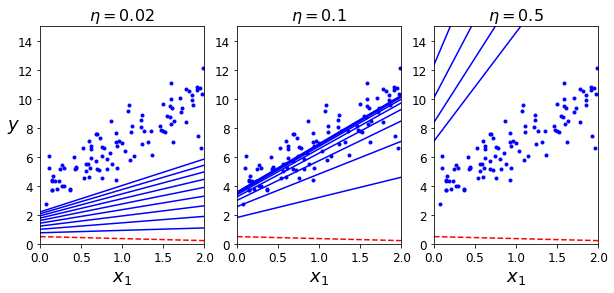

In [14]:
# eta(learning rate)를 변경해가며 찾아가는 과정 시각화
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

# '''
# eta가 0.02인 경우, 10번의 학습만으로는 최적의 theta에 근접하지 못함.
# eta가 0.1인 경우, 10번의 학습만으로 최적의 theta에 근접함.
# eta가 0.5인 경우, 10번의 학습임에도 최적의 theta를 벗어남.
# '''

### 확률적 경사 하강법

In [15]:
# theta 값의 변화를 확인하기 위한 list
theta_path_sgd = []

# X_b의 첫번째 차원과 동일하게 100의 값을 저장
m = len(X_b)

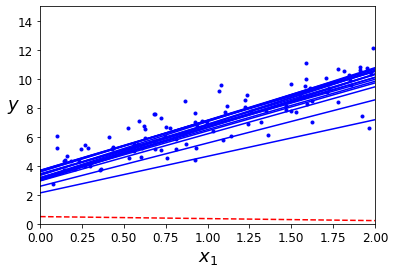

In [16]:
# 전체 샘플을 모두 다 사용하는 것을 50회 반복
n_epochs = 50

# 학습 스케줄 하이퍼파라미터로 eta값이 0.1에서 점점 작아지게 설정
t0, t1 = 5, 50  

def learning_schedule(t):
    return t0 / (t + t1)

# theta 랜덤 초기화
np.random.seed(42)
theta = np.random.randn(2,1)

# 학습과정 시각화 함수 정의
for epoch in range(n_epochs):
    for i in range(m):
        # 20회만 그래프로 표현
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # 최적의 값에 도달할 수록 eta가 작아질 수 있도록 설정
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

# '''
# 대부분 동일한 샘플을 뽑지 않도록 중복을 허용하지 않는 샘플링 방법을 사용함.
# 모든 샘플이 한 epoch안에서 다 사용될 수 있도록 한 것임.
# '''

In [17]:
# 경사하강법을 통한 선형회귀 모델인 SGDRegressor 사용
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

# '''
# max_iter는 epoch 수를 의미함.
# tol은 손실함수의 값 변화가 해당 값보다 적을 경우 학습을 멈추라는 조기종료 조건임.
# penalty는 Ridge나 Lasso 모델에 사용될 것임.
# eta0는 손실함수와 조금 다른 방식으로 수행됨.
# learning_rate는 이 eta0를 활용해 어떻게 수행할 지에 대한 결정을 하는 매개변수임.
# sgd_reg모델은 label값으로 1차원을 요구하기 떄문에 ravel 메서드로 y를 1차원화 시킴.
# '''

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [18]:
# 확률적 경사하강법 구현과 sklearn의 sgd_reg 모델의 예측값 확인
print('확률적 경사하강법을 구현해 예측한 theta : {}'.format(theta.ravel()))
print('sgd_reg가 예측한 theta : {}, {}'.format(sgd_reg.intercept_, sgd_reg.coef_))

확률적 경사하강법을 구현해 예측한 theta : [3.81253976 3.14104447]
sgd_reg가 예측한 theta : [3.87669824], [3.25389018]


### 미니배치 경사하강법

In [19]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    # 중복을 허용하지 않는 샘플링
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

# theta 값 확인
theta

array([[3.89933359],
       [3.30547397]])

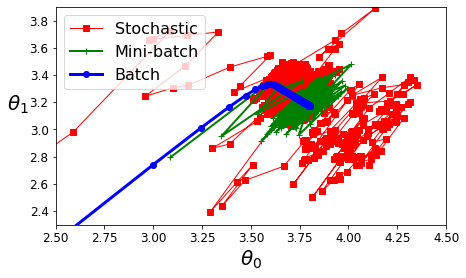

In [20]:
# 각 방법의 학습 경로 시각화
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

### 다항 회귀

In [21]:
# -3~3의 균등분포한 X값과 2차 방정식 형태의 y값 100개 생성
import numpy as np
import numpy.random as rnd

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

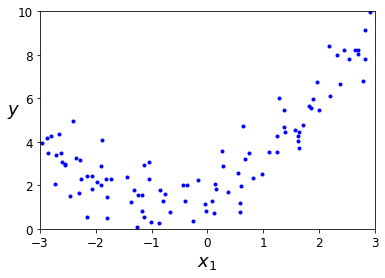

In [22]:
# 데이터 셋 시각화
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [23]:
# X 데이터셋의 특성 확장
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# '''
# PolynomialFeature는 기존 특성을 곱하거나 제곱하여 데이터 셋이 가지고 있는 특성을 늘려줌.
# degree는 각 특성을 최대 n만큼 제곱하는 매개변수임.
# include_bias는 편향을 위한 특성열을 추가함. 디폴트는 True임.
# '''

In [24]:
# 기존 X와 특성을 확장한 X 확인
print('X[0] : {} \nX_poly[0] : {}'.format(X[0], X_poly[0]))

# '''
# 만약 a, b, c 특성을 가진 데이터셋에 degree를 3으로 설정한다면 아래와 같이 특성이 확장됨.
# 1, a, b, c, a2, b2, c3, ab, ac, bc, a3, b3, c3, a2b, a2c, b2c, bc2, abc
# interaction_only 매개변수를 True 놓으면, 한 특성만 제곱한 특성은 추가하지 않음.
# '''

X[0] : [-0.75275929] 
X_poly[0] : [-0.75275929  0.56664654]


In [25]:
# 추가된 특성의 정보 확인
poly_features.get_feature_names()

['x0', 'x0^2']

In [26]:
# lin_reg를 통해 예측 및 값 확인
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

# '''
# lin_reg는 intercept를 계산 할 수 있기 때문에, 특성을 확장할 때 절편을 추가하더라도 문제가 되지 않음.
# 단 coef_의 index 0번 항이 0값으로 나오기 때문에, 어색할 수 있음.
# lin_reg 객체 생성 시 fit_intercept 매개변수를 False로 놓으면, intercept를 학습하지 않음.
# 위와 같은 경우에 coef_의 index 0번 항이 intercept값이 됨.
# '''

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

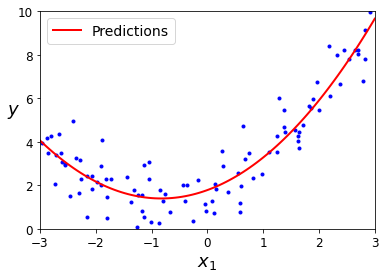

In [27]:
# 실제 데이터와 예측한 회귀선 시각화
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

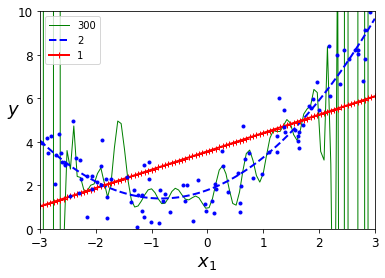

In [28]:
# 데이터에 대한 과대 및 과소적합 시각화
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

# '''
# lin_reg 모델은 해석적으로 해를 구하는 모델로 scale에 민감하지 않음.
# 그럼에도 scaling을 수행한 이유는 300차원이 될 경우 값이 매우 커져서 계산에 문제가 생기기 때문임.
# lin_reg 객체를 생성할 때 nomalize 옵션을 True주는 방법도 있음.
# '''

In [29]:
# 모델의 MSE를 시각화 하는 함수 정의
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

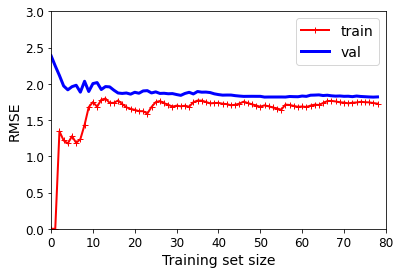

In [30]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

# '''
# train과 val의 RMSE값이 너무 일찍 가까워지고, 두 값의 사이가 매우 좁음.
# 이는 과소적합을 의심할 수 있는 근거임.
# '''

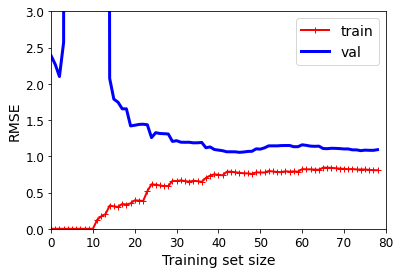

In [31]:
# 다항특성을 추가하여 모델의 복잡도 조정 및 시각화
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

# '''
# 이를 통해 아래와 같은 결과를 얻음.
# RMSE의 전체적인 값이 내려감.
# train과 val의 RMSE 값의 차이가 좁아지는 구간이 미뤄짐.
# 두 값의 차이의 거리가 매우 좁지는 않음.
# '''

### 규제가 있는 모델

In [32]:
# 랜덤한 데이터 셋 20개 생성
np.random.seed(42)
m = 20

# 0~3의 랜덤한 값을 가지는 (100, 1)차원 X데이터 셋 생성
X = 3 * np.random.rand(m, 1)

# 0.5X + 1에 노이즈가 있는 y데이터 셋 생성
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

# 0~3의 값을 갖는 새로운 데이터 셋 생성
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Ridge Regression

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 $

In [33]:
# Ridge 객체 사용
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

# '''
# alpha는 규제의 양을 결정하는 매개변수임.
# solver는 행렬분해 방식으로 기본값은 auto임.
# 'cholesky'는 희소행렬과 같은 특이행렬이 아닌 경우에 사용 됨.
# 'sag'는 내부적으로 경사하강법을 통해 값을 구하도록 함.
# 'saga'는 데이터가 큰 경우에 사용될 수 있음.
# '''

array([[1.55071465]])

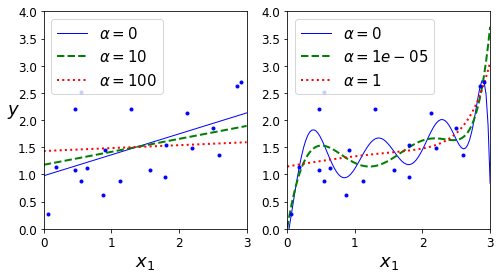

In [34]:
# alpha 값에 대한 모델의 변화 시각화
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

# '''
# 규제가 있는 모델은 theta값을 통해 손실비용을 계산하기 때문에 scale을 해야 함.
# 그렇지 않은 경우 모든 변수를 고르게 계산하지 못하고, 값이 큰 변수에 치우침.
# 단항 회귀의 경우에 alpha값이 커짐에 따라 기울기가 낮아짐.
# 다항 회귀의 경우에 alpha값이 커짐에 따라 복잡도가 낮아짐.
# '''

In [35]:
# sgd_reg 모델에 penalty를 l2로 설정하여 Ridge와 유사한 모델 생성
sgd_reg = SGDRegressor(penalty='l2', max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

Lasso Regression

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| $

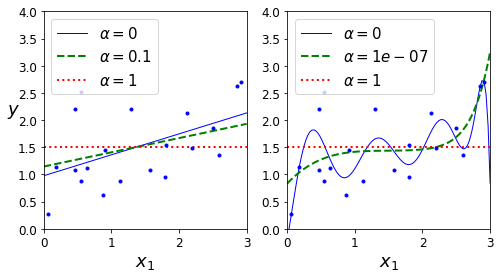

In [36]:
# alpha값에 따른 Lasso 객체의 예측 시각화
from sklearn.linear_model import Lasso

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.show()

# '''
# Ridge와 비슷하나, alpha가 1일때 기울기가 0이 된다는 특징이 있음.
# '''

ElasticNet Regression

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2} $

In [37]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

# '''
# alpha는 마찬가지로 규제의 세기를 결정함.
# L1과 L2규제는 비율에 따라 선택됨.
# l1_ratio는 L1규제의 비율을 선택하는 매개변수로 1일 경우 L1규제만 100% 사용함.
# Lasso 클래스는 실제로 ElasticNet 클래스를 상속받아 l1_ratio를 1로 놓은 것임.
# Ridge 클래스는 훈련방식이 다른 클래스이므로 l1_ratio를 0으로 놓아도 완전히 동일하지는 않음.
# '''

array([1.54333232])

#### 조기종료

In [38]:
# 테스트를 위한 샘플 데이터 셋 생성
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [39]:
# 샘플 데이터 셋 파이프라인 통과 및 epoch, error 저장
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
# '''
# sgd_reg모델 생성 시 매개변수 설정 이유는 아래와 같음.
# max_iter를 1로 놓고 수동으로 반복시키므로써 각 epoch마다의 값을 저장함.
# tol은 조기종료 되지 않도록 음의 무한대 값을 가짐.
# learning_rate는 기본값이 아닌 constant로 최적점에 가까워져도 eta가 줄어들지 않게 함.
# '''

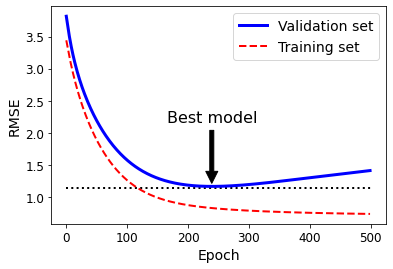

In [40]:
# epoch에 따른 오차 그래프 시각화
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [41]:
# 최적의 epoch, 최저 error, 최적의 model 확인
best_epoch, minimum_val_error, best_model

(239,
 1.3513110512453865,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

In [42]:
# sklearn의 객체에 있는 early_stopping 매개변수 사용
sgd_reg = SGDRegressor(penalty=None, learning_rate='constant', eta0=0.0005,
                      random_state=42, early_stopping=True)
sgd_reg.fit(X_train_poly_scaled, y_train)
y_val_predict = sgd_reg.predict(X_val_poly_scaled)

# mse값과 epoch수 확인
mean_squared_error(y_val, y_val_predict), sgd_reg.n_iter_

# '''
# n_iter_no_change는 디폴트가 5회임.
# early_stopping을 True로 놓았을 경우는 아래와 같음.
# 학습 시 train의 10% 데이터로 검증하고, 그 값이 5번 이상 tol값보다 낮게 개선되는 경우 중단함.
# early_stopping을 False로 놓았을 경우는 아래와 같음.
# 훈련세트에 대한 손실값이, 5번 이상 tol보다 낮게 개선되는 경우 중단함.
# '''

(0.8987688364730185, 293)

### Logistic Regression

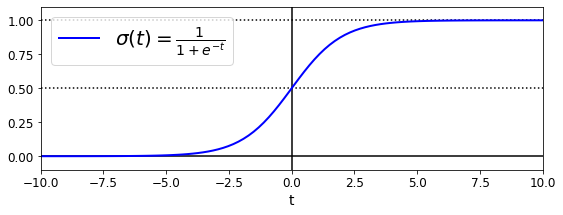

In [43]:
# 시그모이드 함수의 시각화
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

하나의 훈련 샘플에 대한 비용 함수

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) &amp; \text{if } y = 1, \\
  -\log(1 - \hat{p}) &amp; \text{if } y = 0.
\end{cases}
$

로지스틱 회귀 비용 함수(로그 손실)

$ J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} $

로지스틱 비용 함수의 편도 함수

$ \dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)} $

In [44]:
# iris 데이터 셋 로드 및 keys 확인
from sklearn import datasets
iris = datasets.load_iris()

# keys 확인
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [45]:
# target의 클래스별 갯수 확인
np.unique(iris.target, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50]))

In [46]:
# X 데이터 셋의 속성을 1개로 절삭
X = iris.data[:, 3:]

# 이진분류의 형태로 y 데이터셋 변경
y = (iris.target == 2).astype(np.int)

# '''
# X 데이터 셋을 절삭할 때 index 3의 열만 추출함에도 슬라이싱을 쓴 이유는 2차원 배열을 유지하기 위해서임.
# y 데이터 셋은 ==연산자에 의해 True와 False로 값이 변환되고, astype에 의해 1과 0으로 변환됨.
# '''

In [47]:
# LogisticRegression 객체 사용
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

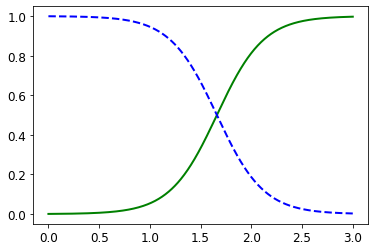

In [48]:
# log_reg의 예측 확률을 시각화
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], 'g-', linewidth=2, label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth=2, label='Not Iris virginica')

# '''
# petal width의 값에 따른 virginica에 대한 양성과 음성 예측 확률임.
# petal width의 값이 작을수록 음성으로, 클수록 양성으로 판정함.
# '''

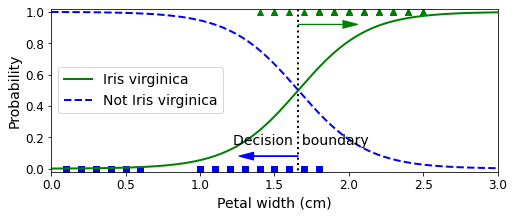

In [49]:
# label의 위치까지 표현한 시각화
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [50]:
# 결정경계 확인
decision_boundary

array([1.66066066])

In [51]:
# 결정경계에 따른 예측값 확인
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [52]:
# 속성 2개로 이진분류 수행하기 위한 데이터 조정
X = iris.data[:, (2, 3)]
y = (iris.target == 2).astype(np.int)

# 객체 생성 및 데이터 셋 학습
log_reg = LogisticRegression(solver='lbfgs', C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

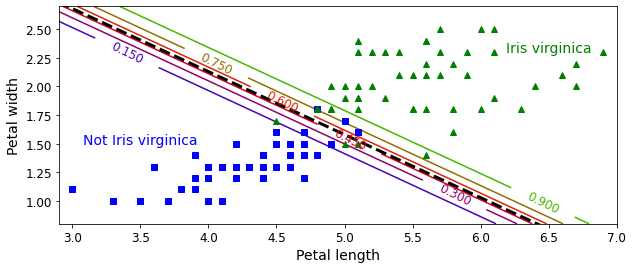

In [53]:
# 결정경계 시각화
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

소프트맥스 함수

$ \hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}} $

크로스 엔트로피 비용 함수

$ J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)} $

클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터

$ \nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}} $



In [55]:
# 결정경계를 시각화 하기 위해 2개의 특성만 사용
X = iris.data[:, (2, 3)]
y = iris.target

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

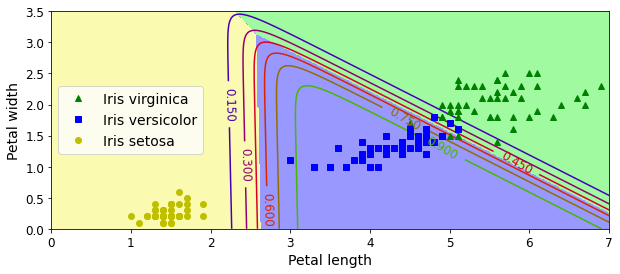

In [56]:
# 결정경계 시각화
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

# 각 클래스에 대한 확률 저장
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [57]:
# 임의의 값에 대한 예측
softmax_reg.predict([[5, 2]])

array([2])

In [58]:
# 임의의 값에 대한 예측 확률
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])